# Rainfall Prediction with 7 Machine Learning Models

## Introduction:
Rainfall prediction is a challenging and uncertain task with substantial impacts on society. Timely and accurate forecasts can proactively mitigate human and financial losses. This study focuses on leveraging common machine learning techniques to predict whether it will rain tomorrow based on weather data from major cities in Australia. By employing ML algorithms, we aim to enhance accuracy in rainfall prediction, particularly benefiting sectors like agriculture and disaster preparedness. Analyzing meteorological variables such as temperature and humidity, our models uncover patterns for more reliable forecasts. With ML's adaptability to real-time data and capability to handle complex relationships, we anticipate significant improvements over traditional methods, thereby facilitating better decision-making across various industries.

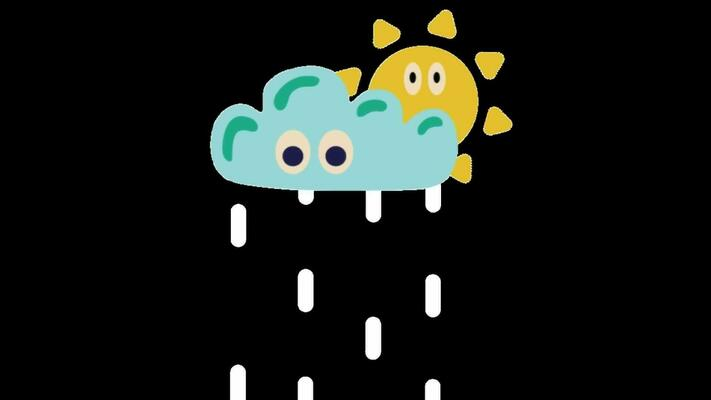

## Importing Datset

In our study, we utilize a dataset sourced from Kaggle, comprising a decade's worth of daily weather observations (2007-2017) from various Australian weather stations. This dataset encompasses 24 features and encompasses 142,193 data entries. To facilitate our analysis, we've uploaded the dataset onto Google Drive for accessibility and further exploration.The original dataset can be found at :

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/download?datasetVersionNumber=2

the google drive link to download it at :

https://drive.google.com/uc?export=download&id=1t2K281W4paE1gOuFtJUHmbc4iKcWiULb

In [ ]:
import requests

# File share link
file_url = "https://drive.google.com/uc?export=download&id=1t2K281W4paE1gOuFtJUHmbc4iKcWiULb"

# Storage path
save_path = "Weather_DataSet.csv"

# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful 
if response.status_code == 200:
    # Write the content of the response to a file
    with open(save_path, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully!")
else:
    print("Failed to download the file. Status code:", response.status_code)


In [ ]:
import pandas as pd
df = pd.read_csv('Weather_DataSet.csv')
df.head()

## Data Exploration

Data exploration is essential for understanding dataset characteristics and patterns. It involves summarizing statistics, visualizing data, and identifying missing values and outliers. This process guides feature engineering and modeling decisions, laying the groundwork for effective analysis and interpretation.

We will first check the number of rows and columns. Next, we’ll check the size of the dataset to decide if it needs size compression

In [ ]:
df.shape

In [ ]:
df.info()

### Visualization of Dataset

In [ ]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

df.dtypes.value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,ax=axarr[1],colors= ['orange','green'])
axarr[1].set_title("Dataset Division ", fontsize=18)

df.dtypes.value_counts().plot(kind='bar',ax=axarr[0],color= ['orange','green'])
plt.title('Dataset Division');
axarr[0].set_title("type of our data ", fontsize=18)

### Convertion of ***“RainToday”*** and ***“RainTomorrow”*** which are objects in the form of (Yes / No) to binary (1/0) for our convenience.

In [ ]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

### Checking whther Dataset is imbalanced.
If the data set is unbalanced, the majority is either downsampled or the minority is oversampled to balance it.

In [ ]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['orange','green'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

### Handling Class Imbalance

It is observed that the presence of “0” and “1” is almost in the 78:22 ratio. This indicates class imbalance and so for further use it needs to be handled.To remove the the class imbalance here, the minority needs to be oversampled. Subsampling the majority class wouldn't be beneficial due to the dataset's small size, as it could potentially lead to information loss and bias in the model training process.

In [ ]:
from sklearn.utils import resample

no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

# Plot the distribution after oversampling
fig = plt.figure(figsize=(8, 5))
oversampled['RainTomorrow'].value_counts(normalize=True).plot(kind='bar', color=['orange', 'green'], alpha=0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()


### Checking for missing datas in Dataset

In [ ]:
# create a table with data missing
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing ,
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame


### Visualizing missing datas

In [ ]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='Reds')

***“Evaporation”***, ***“Sunshine”***, ***“Cloud9am”***, ***“Cloud3pm”*** are the features with a high missing percentage. So we will check the details of the missing data for these 4 features.

In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

It is observed that the 4 features have less than 50% missing data. So instead of rejecting them completely, we’ll consider them in our model with proper imputation.

## Imputation and Transformation
We will impute the categorical columns with mode, and then we will use the label encoder to convert them to numeric numbers. Once all the columns in the full data frame are converted to numeric columns, we will impute the missing values ​​using the Multiple Imputation by Chained Equations (MICE) package.

Then we will detect outliers using the interquartile range and remove them to get the final working dataset. Finally, we will check the correlation between the different variables, and if we find a pair of highly correlated variables, we will discard one while keeping the other.

In [ ]:
oversampled.select_dtypes(include=['object']).columns

In [ ]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [ ]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

We observe that the original dataset had the form (87927, 24). After running a code snippet for removing outliers, the dataset now has the form (86065, 24). As a result, the dataset is now free of 1862 outliers. We are now going to check multicollinearity, that is to say if a character is strongly correlated with another.

In [ ]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap='Reds', vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

The following feature pairs have a strong correlation with each other:

     * MaxTemp and MinTemp
    * Pressure9h and pressure3h
    * Temp9am and Temp3pm
    * Evaporation and MaxTemp
    * MaxTemp and Temp3pm But in no case is the correlation value equal to a perfect “1”. We are therefore not removing any functionality

However, we can delve deeper into the pairwise correlation between these highly correlated characteristics by examining the following pair diagram. Each of the paired plots shows very clearly distinct clusters of RainTomorrow’s “yes” and “no” clusters. There is very minimal overlap between them.

In [ ]:

# Define a custom color palette
custom_palette = ["green", "orange"]  # Specify colors as needed

# Use pairplot with the custom color palette
sns.pairplot(data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow', palette=custom_palette)


In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Location', y='Rainfall')
plt.title('Boxplot of Rainfall by Location')
plt.xlabel('Location')
plt.ylabel('Rainfall')
plt.xticks(rotation=90)
plt.show()


## Feature Selection for Rainfall Prediction
We use both the filter method (chi-square value) and the wrapper method (Random Forest) for feature selection to train our rainfall prediction model.

Selecting features by filtering method: before doing this, we must first normalize our data. We use MinMaxScaler instead of StandardScaler in order to avoid negative values.

In [19]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [20]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


### Selection of features by wrapping method (random forest):

In [21]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


## Training Rainfall Prediction Model with Different Models
We will divide the dataset into training (75%) and test (25%) sets respectively to train the rainfall prediction model. For best results, we will standardize our X_train and X_test data:

In [22]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [23]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [24]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test, y_pred, digits=5))
    
    # Plot ROC curve
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    # Generate confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model, accuracy, roc_auc, coh_kap, time_taken


### 1.Logistic Regression Model

Accuracy = 0.7952798350051561
ROC Area under Curve = 0.7895421146723749
Cohen's Kappa = 0.5823246558119864
Time taken = 2.6686019897460938
              precision    recall  f1-score   support

         0.0    0.80459   0.83764   0.82078     23879
         1.0    0.78229   0.74144   0.76132     18789

    accuracy                        0.79528     42668
   macro avg    0.79344   0.78954   0.79105     42668
weighted avg    0.79477   0.79528   0.79460     42668



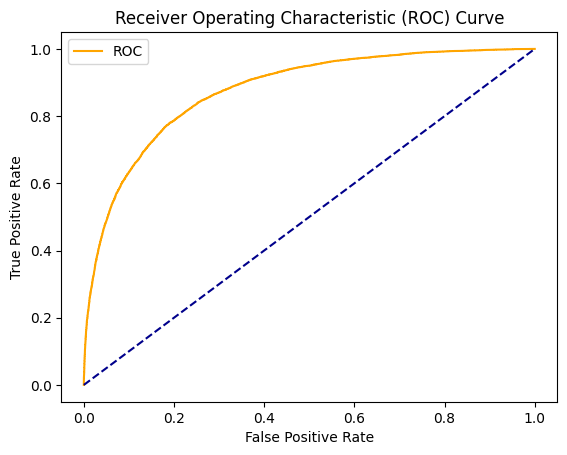

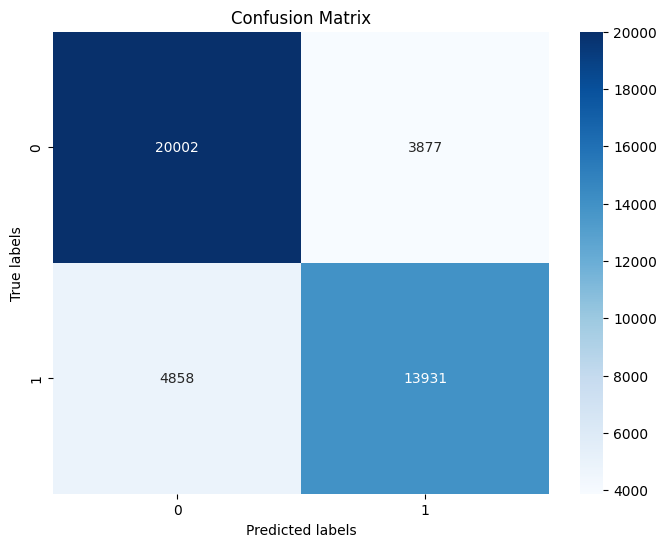

In [26]:
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)



### 2.Decision Tree Model

Accuracy = 0.8633636448860973
ROC Area under Curve = 0.8640401397815856
Cohen's Kappa = 0.7242432133353376
Time taken = 0.35256004333496094
              precision    recall  f1-score   support

         0.0    0.89331   0.85837   0.87549     23879
         1.0    0.82853   0.86971   0.84862     18789

    accuracy                        0.86336     42668
   macro avg    0.86092   0.86404   0.86205     42668
weighted avg    0.86478   0.86336   0.86366     42668



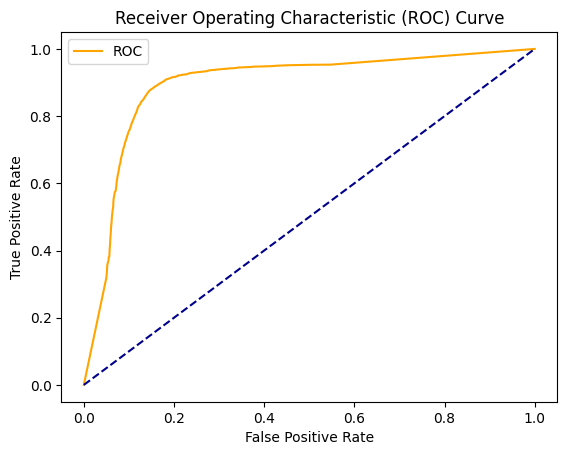

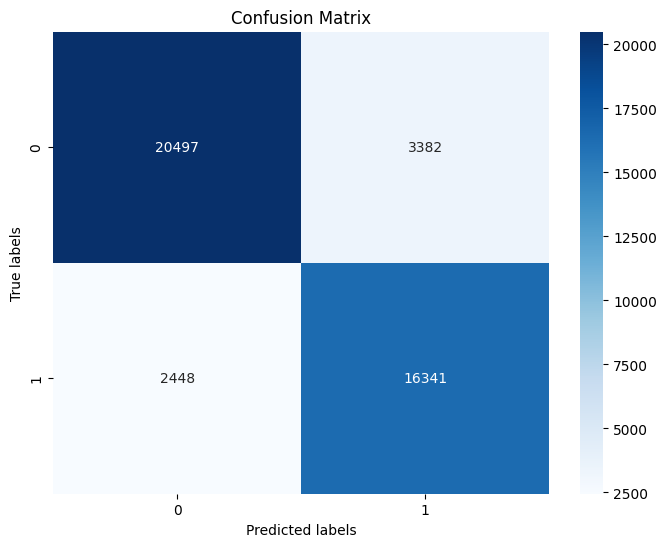

In [27]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)



### 3.Random Forest

Accuracy = 0.9265960438736289
ROC Area under Curve = 0.9279584837896794
Cohen's Kappa = 0.8517906871231153
Time taken = 20.942716121673584
              precision    recall  f1-score   support

         0.0    0.95053   0.91654   0.93323     23879
         1.0    0.89854   0.93938   0.91851     18789

    accuracy                        0.92660     42668
   macro avg    0.92454   0.92796   0.92587     42668
weighted avg    0.92764   0.92660   0.92674     42668



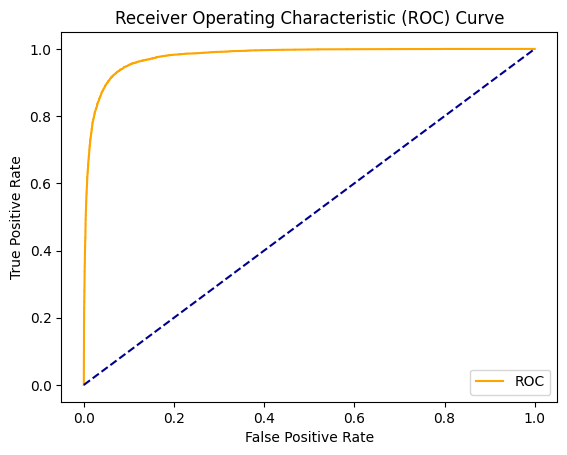

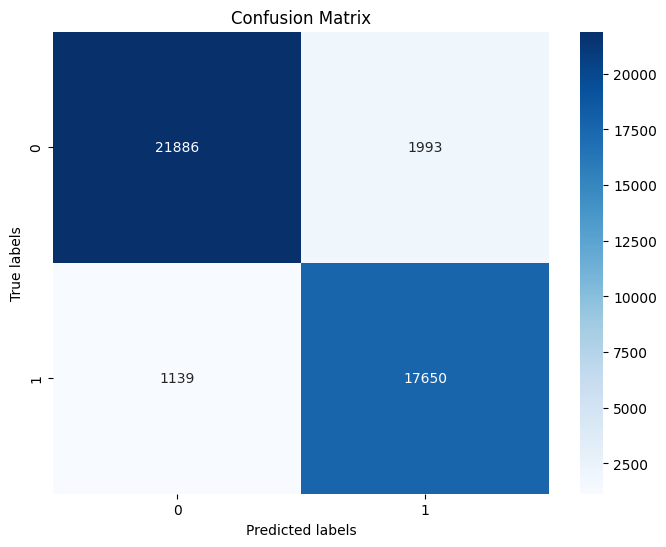

In [28]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)



### 4.Sample Vector Machine Model

In [ ]:
from sklearn.svm import SVC

model_svm = SVC(probability=True)
model_svm, accuracy_svm, roc_auc_svm, coh_kap_svm, tt_svm = run_model(model_svm, X_train, y_train, X_test, y_test)



### 4.Light GBM

[LightGBM] [Info] Number of positive: 56230, number of negative: 71771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4324
[LightGBM] [Info] Number of data points in the train set: 128001, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439293 -> initscore=-0.244030
[LightGBM] [Info] Start training from score -0.244030
Accuracy = 0.8662698040686229
ROC Area under Curve = 0.8634883731799748
Cohen's Kappa = 0.7282159692817018
Time taken = 1.2138357162475586
              precision    recall  f1-score   support

         0.0    0.87580   0.88680   0.88127     23879
         1.0    0.85380   0.84017   0.84693     18789

    accuracy                        0.86627     42668
   macro avg    0.86480   0.86349   0.86410     42668
weighted avg    0.86612   0.86627   0.86615     42668



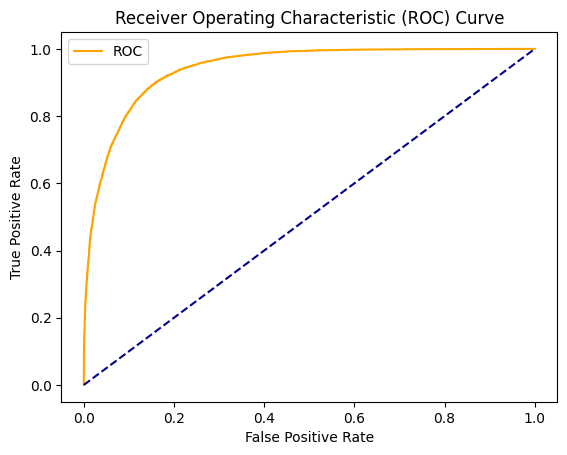

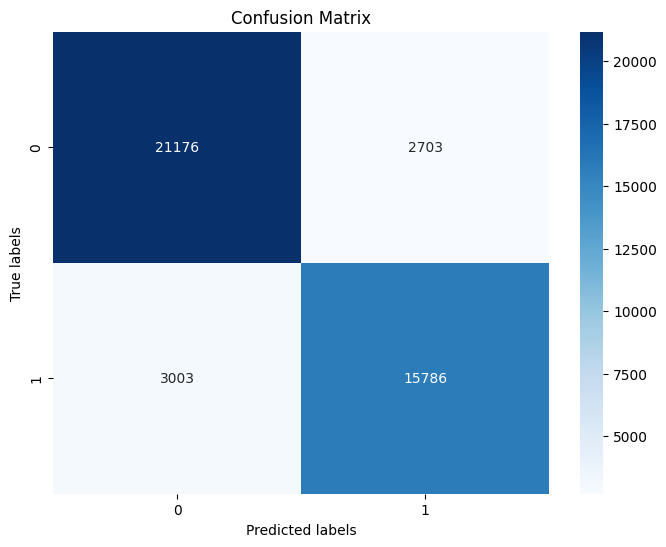

In [30]:
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)



### 5.Catboost

Defaulting to user installation because normal site-packages is not writeable


TBB Warning: The number of workers is currently limited to 11. The request for 23 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Accuracy = 0.9392050248429736
ROC Area under Curve = 0.9424115092864753
Cohen's Kappa = 0.8776540964755455
Time taken = 101.05502581596375
              precision    recall  f1-score   support

         0.0    0.97429   0.91553   0.94400     23879
         1.0    0.90029   0.96929   0.93352     18789

    accuracy                        0.93921     42668
   macro avg    0.93729   0.94241   0.93876     42668
weighted avg    0.94170   0.93921   0.93938     42668



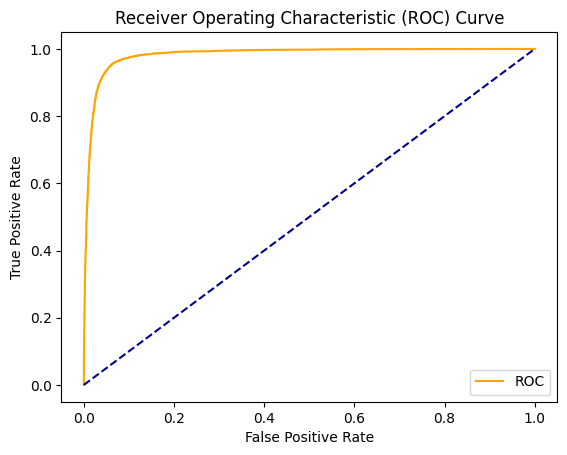

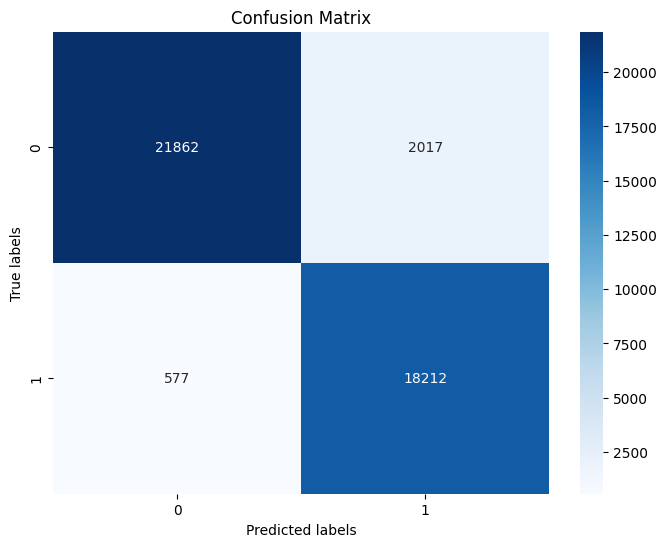

In [31]:
!pip install catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)



### 6.XGBoost

Accuracy = 0.9496109496578232
ROC Area under Curve = 0.9524401225294207
Cohen's Kappa = 0.8984891049787654
Time taken = 42.19823908805847
              precision    recall  f1-score   support

         0.0    0.98020   0.92872   0.95377     23879
         1.0    0.91508   0.97616   0.94463     18789

    accuracy                        0.94961     42668
   macro avg    0.94764   0.95244   0.94920     42668
weighted avg    0.95152   0.94961   0.94975     42668



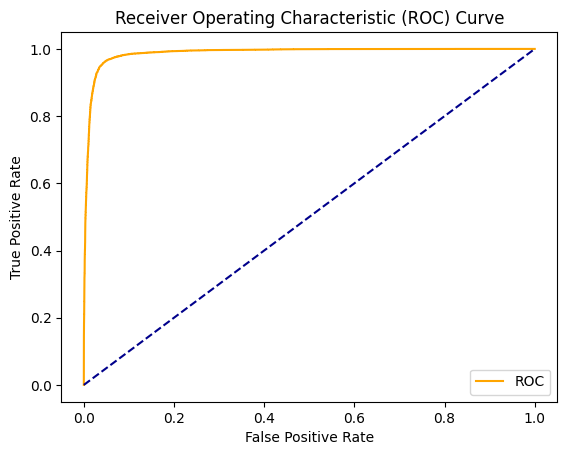

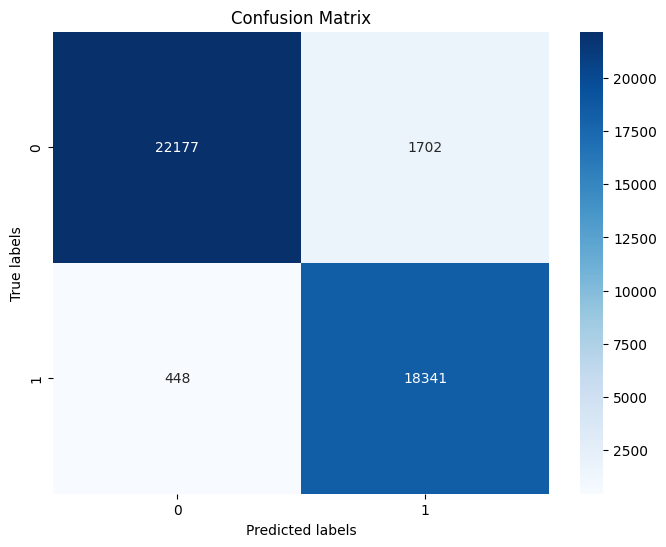

In [32]:
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

## Rainfall Prediction Model Evaluation
The determination of the most suitable rainfall prediction model relies upon the assessment of critical metrics, including Precision Score, ROC_AUC, Cohen’s Kappa, and Total Run Time. While F1-Score could have been a contender, we have opted for accuracy as the metric of choice, given the conversion of our dataset from unbalanced to balanced. Cohen’s Kappa, renowned for its applicability to unbalanced datasets, provides valuable insights into model performance.

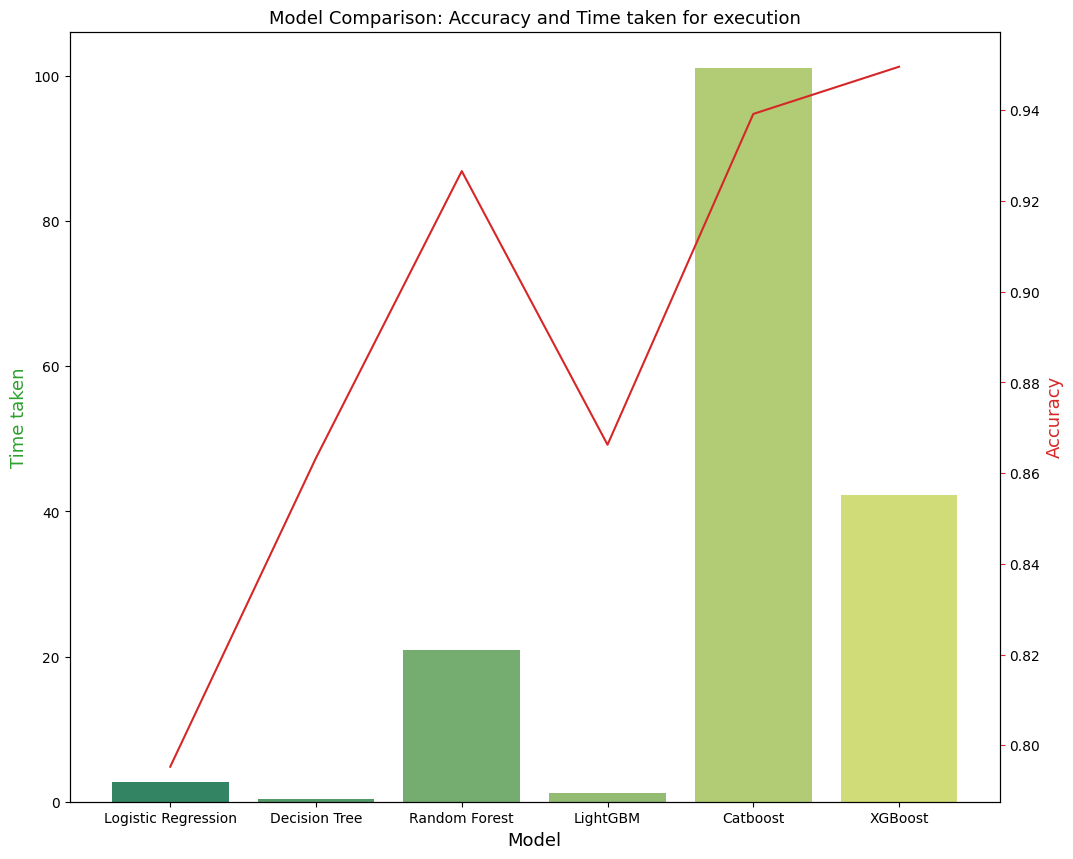

In [33]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

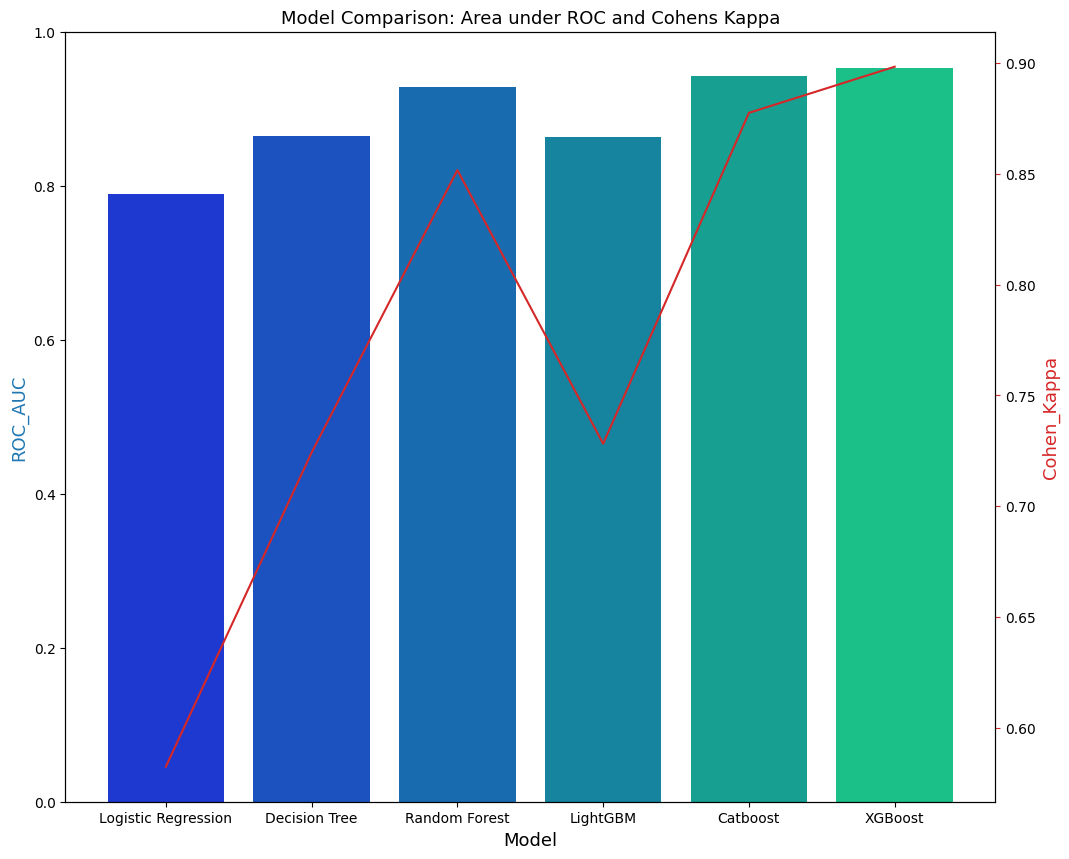

In [34]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

### Among the models evaluated, XGBoost, CatBoost, and Random Forest consistently outperformed the others. Notably, Random Forest exhibited superior performance in terms of speed compared to XGBoost and CatBoost.

## Exporting the Best Model: ***Random Forest***
The library `pickle` is used to export the selected model for future use, ensuring its seamless retrieval and application in subsequent tasks.

In [35]:
import pickle
with open('Rainfall_Prediction_Using_Random_Forest', 'wb') as file:
    pickle.dump(model_rf, file)